# 預處理流程

清emoji、@@username、url -> 存成clean_text

In [1]:
# pip install emoji
# !pip install pandas

In [2]:
import pandas as pd
import re

In [ ]:
# df = pd.read_csv('comments/face2face_comments_merged.csv', encoding='utf-8')
# print(f"一共有 {len(df)} 筆留言")

一共有 105186 筆留言


In [18]:
# 取不重複留言者姓名

def get_name_list(data):
    data['author_name'] = data['author_name'].apply(lambda x: str(x).strip())

    name_set = set()
    for name in data['author_name']:
        clean_name = name.strip()
        if clean_name:
            name_set.add(clean_name)

    return list(name_set)


# name_list = get_name_list(df)
# print(">>> name_list:", name_list)  
# print(f"一共有 {len(name_list)} 個不重複留言者")

In [17]:
import re
import emoji

def cleaning_text(comment_data, name_list):
    """
    對 comment_data（DataFrame，須包含欄位 'comment_text' 與 'video_title'）做以下步驟：
      1. 移除所有 HTML 標籤
      2. 移除 HTML 實體字符（如 &quot;)
      3. 移除 emoji
      4. 移除 @@username（name_list 裡定義的完整用戶名）
      5. 移除所有標點符號（保留中文字、英文字母、數字、空格）
      6. 第二次掃描：移除 name_list 中所有殘留的用戶名（不帶 @@）
      7. 清理多餘空格、過濾空白留言、計算各 video_title 掉了幾筆
    回傳 (df_cleaned, drop_count)，分別是清理後的 DataFrame 與掉落統計。
    """

    # 複製一份 comment_text 作為 cleaned_text
    df = comment_data.copy()
    df['cleaned_text'] = df['comment_text'].astype(str)

    # 1. 移除所有 HTML 標籤（<a>、<br>、<b> 以及其他任何 <...>）
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: re.sub(r'<a href=.*?>.*?</a>|<br>|</?b>|<[^>]+>', ' ', x)
    )

    # 2. 移除 HTML 實體字符，如 &quot; &amp; 等
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: re.sub(r'&[a-zA-Z]+;', '', x)
    )

    # 3. 移除 emoji（使用 emoji 套件）
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: emoji.replace_emoji(x, replace='')
    )

    # 4. 移除所有 @@username（完整 username 來源於 name_list）
    #    先 build 一個正則：@@(user1|user2|user3)…，精確對應 name_list 裡的每個項目
    if name_list:
        pattern_at = r'@@(' + '|'.join(map(re.escape, name_list)) + r')'

        df['cleaned_text'] = df['cleaned_text'].apply(
            lambda x: re.sub(pattern_at, ' ', x)
        )

    # 5. 清理一次多餘空格（避免後面步驟有連續空格）
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: re.sub(r'\s+', ' ', x).strip()
    )

    # 6. 移除標點符號，保留中文字、英文字母、數字、空格
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: re.sub(r'[^\w\s\u4e00-\u9fa5]', ' ', x)
    )

    # 7. 第二次掃描：把 name_list 裡還留在文字裡（不帶 @@）的用戶名都移除
    def remove_remaining_usernames(text):
        for name in name_list:
            text = text.replace(name, ' ')
        return re.sub(r'\s+', ' ', text).strip()

    df['cleaned_text'] = df['cleaned_text'].apply(remove_remaining_usernames)

    # 8. 去除空白留言
    df_cleaned = df[df['cleaned_text'].str.strip() != '']

    # 9. 計算各 video_title 在這一步被清掉的筆數
    original_counts = comment_data.groupby('video_title').size()
    after_counts = df_cleaned.groupby('video_title').size().reindex(original_counts.index, fill_value=0)
    drop_count = original_counts - after_counts
    print(f"過濾掉 {len(drop_count)} 筆留言")

    return df_cleaned


In [20]:
# 賀瓏分集檢查 'cleaned_text' 的姓名有沒有除乾淨

for i in range(0, 36):
    file_path = f"hello_comments/for_bert/video_{i}_ckip.csv"
    temp_df = pd.read_csv(file_path, encoding='utf-8')
    print(f">>> Processing video_{i} with {len(temp_df)} comments")

    # 取得不重複留言者姓名
    name_list = get_name_list(temp_df)
    # print(f">>> name_list for video_{i}: {name_list}")

    # check cleaned_text
    cleaned_df = cleaning_text(temp_df, name_list)
    cleaned_df.to_csv(f'hello_comments/for_bert/video_{i}_ckip_cleaned.csv', index=False)

>>> Processing video_0 with 1948 comments
過濾掉 1 筆留言
>>> Processing video_1 with 13270 comments


KeyboardInterrupt: 

# 計算互動

- 技術性互動：top_comment/reply/single
- 實質討論：reply/@@username

In [ ]:
# df = pd.read_csv('comments/face2face_cleaned.csv')

In [12]:

def tag_interact(df, name_list):
    """
    top_interaction: 留言串的第一則
    single: 沒有任何互動的單一留言
    reply: comment_type == "reply" or @@usename in comment_text
    """
    video_id_map = {title: idx + 1 for idx, title in enumerate(df['video_title'].unique())}
    df['video_id'] = df['video_title'].map(video_id_map)

    # 建立結果列表
    discussion_results = []
    
    # 針對每部影片獨立處理
    for vid in df['video_id'].unique():
        mask = df['video_id'] == vid  # mask是用來抓出特定影片資料
        print(f"=== 處理影片 {vid} ===")
        sub_df = df[mask].reset_index()

        for i in range(len(sub_df)):
            current_row = sub_df.iloc[i].copy()
            current_type = current_row['comment_type']
            next_type = sub_df.iloc[i + 1]['comment_type'] if i + 1 < len(sub_df) else None

            if current_type == 'top_comment' and next_type == 'reply':
                current_row['interaction_type'] = "top_interaction"
            
            elif current_type == 'top_comment' and next_type == 'top_comment':
                for name in name_list:
                    if f"@@{str(name)}" in current_row['comment_text']:
                        current_row['interaction_type'] = "reply"
                    else:
                        current_row['interaction_type'] = "single"
            
            elif current_type == 'reply':
                current_row['interaction_type'] = "reply"

            discussion_results.append(current_row)
    
    # 將結果轉換為 DataFrame
    result_df = pd.DataFrame(discussion_results)
    
    # 儲存結果到 CSV
    result_df.to_csv('comments/face2face_discussion_group.csv', index=False)
    
    
    return result_df

# interaction_tag = tag_interact(df, names)

In [13]:
# count interaction type
def count_dc_group(df: pd.DataFrame) -> pd.DataFrame:
    result = []

    for vid in df['video_id'].unique():
        sub_df = df[df['video_id'] == vid]
        video_title = sub_df['video_title'].iloc[0]

        # 實質互動留言數：有參與討論串的留言
        interactive_comments = sub_df[sub_df['interaction_type'] != 'single'].shape[0]

        # 總留言數
        total_comments = sub_df.shape[0]

        # 實質互動比例
        interaction_ratio = interactive_comments / total_comments

        result.append({
            'video_id': vid,
            'video_title': video_title,
            'total_comments': total_comments,
            'interactive_comments': interactive_comments,
            'interaction_ratio': round(interaction_ratio, 
                                       4)
        })

    result_df = pd.DataFrame(result)
    result_df.to_csv('comments/face2face_discussion_counts.csv', index=False)

    return result_df

# interaction_counts = count_dc_group(interaction_tag)

# Spam tag

### 計算留言長度極端值

In [3]:
# combine all cleaned_comments

temp_df = []

for i in range(0, 36):
    if i in [10, 11, 12, 16, 17]:
        print(f"跳過 video_{i}")
        continue

    print(f"\n=== 處理 video_{i} ===")
    file_name = f'hello_comments/for_bert/video_{i}_ckip_cleaned.csv'
    df = pd.read_csv(file_name, encoding='utf-8')

    for idx, row in df.iterrows():
        comment = row['cleaned_text']
        length = len(comment)
        temp_df.append({'comment': comment, 'length': length})

cleaned_comment_df = pd.DataFrame(temp_df)
cleaned_comment_df = cleaned_comment_df.drop_duplicates().reset_index(drop=True)
cleaned_comment_df.to_csv('for_gpt_tag/all_comments_df.csv', index=False, encoding='utf-8')


=== 處理 video_0 ===

=== 處理 video_1 ===

=== 處理 video_2 ===

=== 處理 video_3 ===

=== 處理 video_4 ===

=== 處理 video_5 ===

=== 處理 video_6 ===

=== 處理 video_7 ===

=== 處理 video_8 ===

=== 處理 video_9 ===
跳過 video_10
跳過 video_11
跳過 video_12

=== 處理 video_13 ===

=== 處理 video_14 ===

=== 處理 video_15 ===
跳過 video_16
跳過 video_17

=== 處理 video_18 ===

=== 處理 video_19 ===

=== 處理 video_20 ===

=== 處理 video_21 ===

=== 處理 video_22 ===

=== 處理 video_23 ===

=== 處理 video_24 ===

=== 處理 video_25 ===

=== 處理 video_26 ===

=== 處理 video_27 ===

=== 處理 video_28 ===

=== 處理 video_29 ===

=== 處理 video_30 ===

=== 處理 video_31 ===

=== 處理 video_32 ===

=== 處理 video_33 ===

=== 處理 video_34 ===

=== 處理 video_35 ===



📊 留言長度統計:
count    135849.000000
mean         40.319840
std          88.956169
min           1.000000
25%          11.000000
50%          21.000000
75%          41.000000
max        3526.000000
Name: length, dtype: float64

📈 百分位數:
第 1百分位:   3.0 字
第 5百分位:   5.0 字
第10百分位:   7.0 字
第25百分位:  11.0 字
第50百分位:  21.0 字
第75百分位:  41.0 字
第90百分位:  82.0 字
第95百分位: 128.0 字
第99百分位: 309.0 字

💡 建議的過濾標準:
極短留言過濾: < 5 字
極長留言過濾: > 128 字
常規範圍: 5 - 128 字

🔍 極端值數量:
極短留言: 9371 筆 (6.90%)
極長留言: 6886 筆 (5.07%)


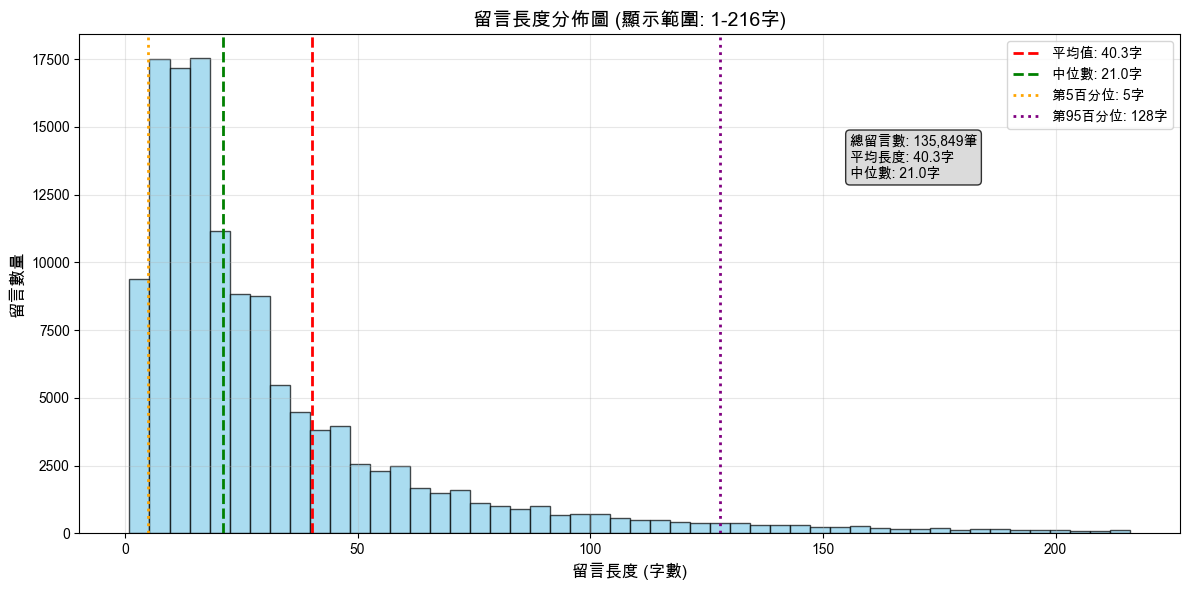


✅ 分析完成！
📁 完整資料已儲存到: for_gpt_tag/all_comments_with_length.csv
📁 分佈圖已儲存到: for_gpt_tag/comment_length_distribution.png


: 

In [ ]:
# 計算統計數據
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

cleaned_comment_df = pd.read_csv('for_gpt_tag/all_comments_df.csv', encoding='utf-8')

# settingn word font
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Arial Unicode MS', 'Helvetica']
plt.rcParams['axes.unicode_minus'] = False

exit()
length_stats = cleaned_comment_df['length'].describe()
print("\n📊 留言長度統計:")
print(length_stats)

# 計算關鍵百分位數
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"\n📈 百分位數:")
for p in percentiles:
    value = cleaned_comment_df['length'].quantile(p/100)
    print(f"第{p:2d}百分位: {value:5.1f} 字")

# 建議的過濾標準
very_short_threshold = cleaned_comment_df['length'].quantile(0.05)
very_long_threshold = cleaned_comment_df['length'].quantile(0.95)

print(f"\n💡 建議的過濾標準:")
print(f"極短留言過濾: < {max(3, very_short_threshold):.0f} 字")
print(f"極長留言過濾: > {very_long_threshold:.0f} 字")
print(f"常規範圍: {cleaned_comment_df['length'].quantile(0.05):.0f} - {cleaned_comment_df['length'].quantile(0.95):.0f} 字")

# 極端值數量統計
very_short_count = len(cleaned_comment_df[cleaned_comment_df['length'] <= very_short_threshold])
very_long_count = len(cleaned_comment_df[cleaned_comment_df['length'] >= very_long_threshold])

print(f"\n🔍 極端值數量:")
print(f"極短留言: {very_short_count} 筆 ({very_short_count/len(cleaned_comment_df)*100:.2f}%)")
print(f"極長留言: {very_long_count} 筆 ({very_long_count/len(cleaned_comment_df)*100:.2f}%)")

# 繪製分佈圖
plt.figure(figsize=(12, 6))

# 限制顯示範圍（去除極端異常值以便更好觀察）
display_max = cleaned_comment_df['length'].quantile(0.98)  # 第98百分位
filtered_for_display = cleaned_comment_df[cleaned_comment_df['length'] <= display_max]['length']

plt.hist(filtered_for_display, bins=50, color='skyblue', alpha=0.7, edgecolor='black')

# 添加統計線
plt.axvline(cleaned_comment_df['length'].mean(), color='red', linestyle='--', 
           label=f'平均值: {cleaned_comment_df["length"].mean():.1f}字', linewidth=2)
plt.axvline(cleaned_comment_df['length'].median(), color='green', linestyle='--', 
           label=f'中位數: {cleaned_comment_df["length"].median():.1f}字', linewidth=2)
plt.axvline(very_short_threshold, color='orange', linestyle=':', 
           label=f'第5百分位: {very_short_threshold:.0f}字', linewidth=2)
plt.axvline(very_long_threshold, color='purple', linestyle=':', 
           label=f'第95百分位: {cleaned_comment_df["length"].quantile(0.95):.0f}字', linewidth=2)

plt.title(f'留言長度分佈圖 (顯示範圍: 1-{display_max:.0f}字)', fontsize=14, fontweight='bold')
plt.xlabel('留言長度 (字數)', fontsize=12)
plt.ylabel('留言數量', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 添加統計信息文本
stats_text = f"總留言數: {len(cleaned_comment_df):,}筆\n"
stats_text += f"平均長度: {cleaned_comment_df['length'].mean():.1f}字\n"
stats_text += f"中位數: {cleaned_comment_df['length'].median():.1f}字"

plt.text(0.7, 0.8, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
         fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig('for_gpt_tag/comment_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 保存完整資料
# cleaned_comment_df.to_csv('for_gpt_tag/all_comments_with_length.csv', index=False, encoding='utf-8-sig')

print(f"\n✅ 分析完成！")
print(f"📁 完整資料已儲存到: for_gpt_tag/all_comments_with_length.csv")
print(f"📁 分佈圖已儲存到: for_gpt_tag/comment_length_distribution.png")

### 客觀條件判斷spam

- 以cleaned_text為主
- 使用者重複留言超過3次相同留言
- 留言字數<5

In [12]:
def count_spammer_comments(df):
    user_counts = df['author_name'].value_counts()
    name_count_list = []
    for name, count in user_counts.items():
        if count > 3:
            name_count_list.append({name: count})
    print(">>> 留言數量大於 3 的使用者：", name_count_list)

    # if same user comment the SAME commnet more than 3 times, spam_tag == 'spam', else 'non-spam'ArithmeticError
    df['spam_tag'] = ''

    for idx, row in df.iterrows():
        comment_text = row['cleaned_text']
        author_name = row['author_name']

        if author_name in user_counts.index and user_counts[author_name] > 3:
            # print(f">>> 正在檢查 {author_name} 的留言")

            if author_name in [list(item.keys())[0] for item in name_count_list]:
                duplicate_comments = df[df['author_name'] == author_name]['cleaned_text'].value_counts()
                
                if duplicate_comments[comment_text] > 3:
                    df.at[idx, 'spam_tag'] = 'spam'
                    # print(f">>> username: {author_name} 重複留言超過3次，標記為spam")

        if len(comment_text) < 5:
            df.at[idx, 'spam_tag'] = 'spam'
            # print(f"{comment_text} >>> 留言過短，標記為spam")
    
    return df 

In [ ]:
# 初始化 count_spam 字典來記錄每個檔案的過濾統計
count_spam = {}

for i in range(0, 36):
    if i in [10, 11, 12, 16, 17]:
        print(f"跳過 video_{i}")
        continue

    print(f"\n=== 處理 video_{i} ===")
    file_name = f'for_bert/video_{i}_ckip_cleaned.csv'
    df = pd.read_csv(file_name, encoding='utf-8')
    original_count = len(df)
    print(f"一共有 {original_count} 筆留言")

    tag_df = count_spammer_comments(df)
    
    filtered_df = df[df['spam_tag'] != 'spam'][['video_title', 'cleaned_text']]
    filtered_count = len(filtered_df)
    print(f"過濾後剩下 {filtered_count} 筆留言")

    # 記錄這個檔案的統計資訊
    count_spam[f'video_{i}'] = {
        'original_count': original_count,
        'filtered_count': filtered_count,
        'spam_count': original_count - filtered_count
    }

    # save to csv
    filtered_df.to_csv(f'for_gpt_tag/video_{i}_filtered_spam.csv', index=False)

# 將統計結果保存為 DataFrame 並輸出到 CSV
spam_stats_df = pd.DataFrame.from_dict(count_spam, orient='index')
spam_stats_df.index.name = 'video_file'
spam_stats_df.to_csv('for_gpt_tag/spam_filter_stats.csv')

# 顯示總計
total_original = spam_stats_df['original_count'].sum()
total_filtered = spam_stats_df['filtered_count'].sum()
print("\n=== 總計 ===")
print(f"總原始留言數: {total_original}")
print(f"過濾後留言數: {total_filtered}")
print(f"過濾掉的留言數: {total_original - total_filtered}")
print(f"總過濾比例: {(total_original - total_filtered) / total_original:.4f}")


=== 處理 video_0 ===
一共有 1948 筆留言
>>> 留言數量大於 3 的使用者： [{'1taichang': 26}, {'翡翠-c9q': 23}, {'哈哈-z1p': 22}, {'image1191': 19}, {'patrickyang5760': 15}, {'gravitywide': 13}, {'alstonc.8964': 12}, {'user-fukakai': 11}, {'wallowes': 9}, {'rayrayrayray7630': 9}, {'UncleJigen': 9}, {'陳志慈-b6g': 8}, {'allen747': 7}, {'kycia12': 6}, {'kevinfan8020': 6}, {'Chou-d8u': 6}, {'蕭秉科-c1r': 5}, {'超營養雞排-o3e': 5}, {'alicelin661': 5}, {'烟一缕': 4}, {'jtang4378': 4}, {'楊繼芬': 4}, {'kokkeonglai2581': 4}, {'香吉士-q1n': 4}, {'推翻共產黨共產黨才是': 4}, {'0鍇': 4}, {'adsmk22': 4}, {'joyoungjin-yc8sb': 4}, {'bobobo0413': 4}]
過濾後剩下 1699 筆留言

=== 處理 video_1 ===
一共有 13270 筆留言
>>> 留言數量大於 3 的使用者： [{'陳小名-r6g': 121}, {'尋思-l7u': 72}, {'Avan-Golf': 65}, {'Alex-q9o1q': 64}, {'kennyko7730': 57}, {'gto-iu1qq': 51}, {'image1191': 50}, {'Fm-qu3ts': 47}, {'GodBlessedyumei': 45}, {'ssf846': 39}, {'mercy204': 37}, {'陳霖涵-r2n': 37}, {'海軍會暈船': 36}, {'kwokgary989': 35}, {'hu5916': 33}, {'Ernst8963': 29}, {'canonhuang4001': 28}, {'473834': 26}, {'bobob

### 人工標注spam/non-spam
spam 的標準：

- 留言過短 （少於5個字）
- 無意義的內容 
    - e.g. 哈哈哈哈哈哈哈、Albee真的好強...、你講支語喔、贺龙好样的
    - 無指涉（缺少主詞） e.g 這集超好笑 真的超有梗、真的很喜歡夜夜秀這個節目 辛苦了
    - 留言內或留言串中內容一直重複
    - 只有批評或讚美 e.g. 所以才是腦殘阿 根本就一昧的跟從 傻B


In [ ]:
"""
人工標注的資料是從每一部影片過濾spammer之後，隨機抽取100則留言組成
"""

import pandas as pd
import os

comments_for_tag = []
stats_data = []  # 用來記錄統計資料

# 修改這裡：處理所有影片
for i in range(0, 36):
    if i in [10, 11, 12, 16, 17]:
        print(f"跳過 video_{i}")
        continue

    file_path = f"spam_tag/video_{i}_ckip_spam_tag.csv"
    # file_path = f"hello_comments/for_bert/video_{i}_ckip_cleaned.csv"
    print(f"Processing video {i} from {file_path}")
    
    # 檢查檔案是否存在
    if not os.path.exists(file_path):
        print(f"  檔案不存在，跳過")
        continue
    
    temp_df = pd.read_csv(file_path)
    original_comment_num = len(temp_df)
    video_title = temp_df['video_title'].iloc[0] if len(temp_df) > 0 else f"Video_{i}"
    
    print(f"  一共有 {original_comment_num} 筆留言")

    # 按比例抽取 2% 的留言，但最少抽100則
    sample_ratio = 0.02  
    calculated_sample_size = max(100, int(original_comment_num * sample_ratio))
    
    # 確保不超過原始留言數
    sample_size = min(calculated_sample_size, original_comment_num)
    
    sampled_comments = temp_df.sample(n=sample_size, random_state=42)
    comments_for_tag.append(sampled_comments)
    
    # 記錄統計資料（每部影片都會append）
    stats_data.append({
        'video_id': i,
        'video_title': video_title,
        'original_comment_num': original_comment_num,
        'tag_comments_num': len(sampled_comments)
    })

    print(f"  抽取了 {len(sampled_comments)} 則留言")

# 建立統計DataFrame
stats_df = pd.DataFrame(stats_data)
print("\n=== 影片留言統計 ===")
print(stats_df)

# 確保有收集到資料
if comments_for_tag:
    tag_comments_all = pd.concat(comments_for_tag, ignore_index=True)
    tag_comments_all = tag_comments_all.reset_index(drop=True)
    tag_comments_all['video_id'] = tag_comments_all['video_title'].map(
        {title: f"v{idx}" for idx, title in enumerate(tag_comments_all['video_title'].unique())}
    )

    tag_comments_all = tag_comments_all[['video_id','cleaned_text','spam_tag']]

    # 儲存抽取的留言
    tag_comments_all.to_csv("spam_tag/comments_spam_tag.csv", index=False)
    print(f"\n抽取的留言已儲存到 spam_tag/comments_spam_tag.csv with {len(tag_comments_all)} comments")
    
    # 修正這裡：完整的方法名稱
    stats_df.to_csv("spam_tag/video_sampling_stats.csv", index=False)
    print(f"統計資料已儲存到 spam_tag/video_sampling_stats.csv")
    
else:
    print("沒有找到任何資料可供處理")

# 顯示最終統計
print(f"\n=== 總計 ===")
print(f"總影片數: {len(stats_df)}")
print(f"總原始留言數: {stats_df['original_comment_num'].sum()}")
print(f"總抽取留言數: {stats_df['tag_comments_num'].sum()}")
print(f"抽取比例: {stats_df['tag_comments_num'].sum() / stats_df['original_comment_num'].sum():.4f}")

# 計算高頻詞，挑選政治同義詞彙

In [1]:
# 載入停用詞
with open('stopwords_zh-tw.txt', 'r', encoding='utf-8') as f:
# with open('/content/drive/MyDrive/comments/stopwords_zh-tw.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()
    stopwords = [word.strip() for word in stopwords]
    print(stopwords)

['\ufeff,', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而', '加之', '假如', '假若', '假使', '鑒於', 

In [2]:
# 清理停用詞
def clean_tokens(tokens):
    return [t for t in tokens if t.strip() not in stopwords]

In [6]:
import pandas as pd
import ast

df = pd.read_csv('hello_comments/for_bert/tag_comments_all.csv', encoding='utf-8')
print(len(df), "筆留言")

try:
    data = df[['video_title', 'cleaned_text', 'ws']]
    data = data.dropna().reset_index(drop=True)

    # 2. 清理斷詞欄位
    data['ws'] = data['ws'].apply(lambda x: ast.literal_eval(x))
    data['ws_cleaned'] = data['ws'].apply(clean_tokens)
    data['ws_cleaned'] = data['ws_cleaned'].apply(lambda x: ' '.join(x))

    # 3. 過濾空白
    data = data[data['ws_cleaned'].str.strip() != ""].reset_index(drop=True)
    print(f"[INFO]清理後的留言數量: {len(data)}")

except Exception as e:
    print(">>> 發生錯誤:", e)
    print(f"[Error]發生錯誤: {e}")
    raise e

2160 筆留言
[INFO]清理後的留言數量: 2143


In [7]:
data.head(5)

,video_title,cleaned_text,ws,ws_cleaned
0,【#賀瓏夜夜秀】1/20 新聞亂報 EP9｜落選夜夜秀謝票大會,假設馬 造謠 郭有涉及伊案 那就看郭有沒有提告馬 如果有提告 這是 件案子 馬...,"[ , 假設, 馬 , 造謠, , 郭, 有, 涉及, 伊案, , 那, 就, 看,...",假設 馬 造謠 郭 涉及 伊案 郭 有沒有 提告 馬 提告 件 案子 馬 軍情...
1,【#賀瓏夜夜秀】1/20 新聞亂報 EP9｜落選夜夜秀謝票大會,鄭 忘了 德欸,"[鄭, , 忘, 了, 德, 欸]",鄭 忘 德 欸
2,【#賀瓏夜夜秀】1/20 新聞亂報 EP9｜落選夜夜秀謝票大會,請問香港人了解華人社會嗎 我們華人 台灣人 是不會跟老闆說東西不好吃的 不好吃只能摸摸鼻子離開,"[請問, 香港人, 了, 解, 華人, 社會, 嗎, , 我們, 華人, , 台灣人, ...",請問 香港人 解 華人 社會 華人 台灣人 老闆 說 東西 好吃 好吃 只 摸摸 鼻子 離開
3,【#賀瓏夜夜秀】1/20 新聞亂報 EP9｜落選夜夜秀謝票大會,阿頭算是少數正向獲利的,"[阿頭, 算是, 少數, 正向, 獲利, 的]",阿頭 算是 少數 正向 獲利
4,【#賀瓏夜夜秀】1/20 新聞亂報 EP9｜落選夜夜秀謝票大會,user fukakai 年轻人会去看吗 台视和Tvbs的播放量和评论量连夜夜秀的零头都不到,"[ user fukakai , 年轻, 人会, 去, 看, 吗 , 台视, 和, Tvb...",user fukakai 年轻 人会 吗 台视 Tvbs 播放量 评论量连 夜夜秀 零头


In [11]:
# use ws_cleaned to count word frequency
from collections import Counter
def count_word_frequency(ws_list):
    word_count = Counter()
    for ws in ws_list:
        words = ws.split()
        word_count.update(words)
    return word_count

In [13]:
word_count = count_word_frequency(data['ws_cleaned'])
# turn into DataFrame
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count'])
word_count_df = word_count_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# save to csv
word_count_df.to_csv('hello_comments/word_frequency.csv', index=False, encoding='utf-8-sig')

In [16]:
# turn personlist into markdown format

person_list = pd.read_csv("person_sync_list.csv", encoding='utf-8')

knowledge_list = []
for idx, row in person_list.iterrows():
    name = row['key']
    position = row['meaning']
    other_name = row['sync']

    knowledge = f"{name} ({position}): {other_name}\n"
    knowledge_list.append(knowledge)

knowledge_text = ''.join(knowledge_list)
# save to markdown file
with open('knowledge_for_relation.txt', 'w', encoding='utf-8') as f:
    f.write(knowledge_text)